<a href="https://colab.research.google.com/github/RaoSharjeelKhan/Machine-Learning/blob/main/Malarial_cell_classification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

100% 672M/675M [00:35<00:00, 23.3MB/s]
100% 675M/675M [00:35<00:00, 19.9MB/s]


In [ ]:
from zipfile import ZipFile
DT="/content/cell-images-for-detecting-malaria.zip"
with ZipFile(DT, 'r') as zipObj:
  zipObj.extractall()

In [ ]:
BATCH_SIZE=32
IMG_DIM=140

In [ ]:
train_set=tf.keras.utils.image_dataset_from_directory(
    '/content/cell_images/cell_images',
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(IMG_DIM, IMG_DIM),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
)
valid_set=tf.keras.utils.image_dataset_from_directory(
    '/content/cell_images/cell_images',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(IMG_DIM, IMG_DIM),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


In [ ]:
class_names=train_set.class_names

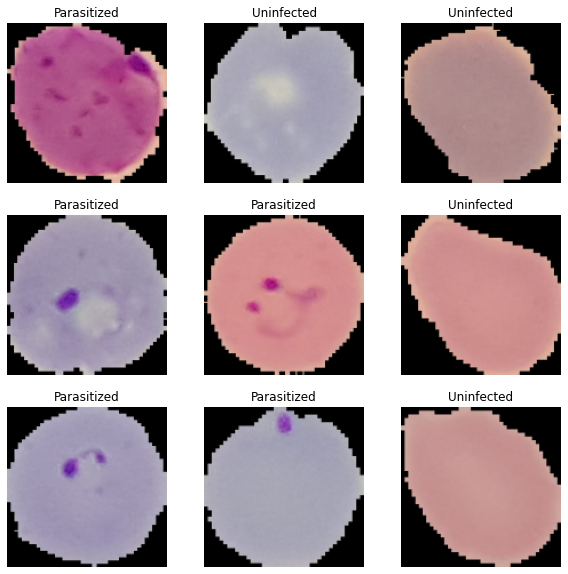

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
num_classes = 2

model = tf.keras.Sequential([
  #pre_processing_layers,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
history=model.fit(
  train_set,
  validation_data=valid_set,
  epochs=10
)

Epoch 1/10
689/689 [==============================] - 26s 37ms/step - loss: 0.4065 - accuracy: 0.8041 - val_loss: 0.2328 - val_accuracy: 0.9185
Epoch 2/10
689/689 [==============================] - 26s 37ms/step - loss: 0.1811 - accuracy: 0.9387 - val_loss: 0.1556 - val_accuracy: 0.9499
Epoch 3/10
689/689 [==============================] - 25s 37ms/step - loss: 0.1478 - accuracy: 0.9520 - val_loss: 0.1545 - val_accuracy: 0.9494
Epoch 4/10
689/689 [==============================] - 26s 38ms/step - loss: 0.1267 - accuracy: 0.9575 - val_loss: 0.1540 - val_accuracy: 0.9521
Epoch 5/10
689/689 [==============================] - 25s 37ms/step - loss: 0.1074 - accuracy: 0.9641 - val_loss: 0.1824 - val_accuracy: 0.9468
Epoch 6/10
689/689 [==============================] - 25s 36ms/step - loss: 0.0911 - accuracy: 0.9682 - val_loss: 0.1762 - val_accuracy: 0.9457
Epoch 7/10
689/689 [==============================] - 25s 36ms/step - loss: 0.0683 - accuracy: 0.9760 - val_loss: 0.2173 - val_accuracy:

In [ ]:
def model_builder(hp):
    # create model object
    model = keras.Sequential([
    #adding first convolutional layer    
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        # adding filter size or kernel size
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        #activation function
        activation='relu',
        input_shape=(IMG_DIM,IMG_DIM,3)),
    # adding second convolutional layer 
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        #adding filter size or kernel size
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        #activation function
        activation='relu'
    ),
    # adding flatten layer    
    keras.layers.Flatten(),
    # adding dense layer    
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    # output layer    
    keras.layers.Dense(10, activation='softmax')
    ])
    #compilation of model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(train_set, epochs=10, validation_data=valid_set)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 5 Complete [00h 02m 27s]
val_accuracy: 0.5084376931190491

Best val_accuracy So Far: 0.6093267798423767
Total elapsed time: 00h 15m 23s

Search: Running Trial #6

Value             |Best Value So Far |Hyperparameter
80                |112               |conv_1_filter
3                 |3                 |conv_1_kernel
48                |48                |conv_2_filter
5                 |5                 |conv_2_kernel
128               |112               |dense_1_units
0.001             |0.001             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
  6/689 [..............................] - ETA: 1:05 - loss: 5001.1753 - accuracy: 0.4479

546/689 [======================>.......] - ETA: 12s - loss: 55.6952 - accuracy: 0.5671